# Simple PINN for an elastic plate with an elliptical hole 

## Geometry

We want to model a quarter of a plate with an elliptical hole. The domain itself is represented by collocation points, the boundaries are represented by uniformly sampled points along the perimeter.

In [281]:
import torch
print(torch.version.cuda)
print(torch.__version__)

11.8
2.2.1+cu118


In [282]:
import torch
from torch.optim.lr_scheduler import StepLR, ExponentialLR, MultiStepLR
import numpy as np
from scipy.stats import qmc
from plotly.express.colors import sequential
import plotly.graph_objects as go
import plotly.figure_factory as ff
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from global_constants import L, R, MU, LBD, N1, N2

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Elliptical axis in x direction
Rx = 0.14
# Elliptical axis in y direction
Ry = R**2 / Rx
# Number of points for one boundary 
N = 25
# Number of collocation points
collo_number = 512

# Number of hidden neurons
hn = 30 #previous value hn->50

# Weight of PDE loss
# W_PDE = 0.00001 #previous value -> 0.001
# # Weight of Neumann loss
# W_NEU = 0.0005 #previous value -> 0.05 
# # Weight of data losses
# W_STRESS = 0.0
# W_DISP = 0.0


# Load reference data
data_input = torch.as_tensor(
    np.loadtxt(f"data/inputs_Rx={Rx}.csv", delimiter=","), device=device
)
print(torch.cuda.is_available())
print(device)
data_output = torch.as_tensor(
    np.loadtxt(f"data/outputs_Rx={Rx}.csv", delimiter=","), device=device
)

# Create collocation points
points = L * qmc.LatinHypercube(d=2).random(N**4)
mask = (((points[:, 0] ** 2) / (Rx**2)) + ((points[:, 1] ** 2) / (Ry**2))) > 1
valid_points = points[mask]
density = 1 / (valid_points[:,0]**2 / Rx**2 + valid_points[:,1]**2 / Ry**2)
selected_points = np.random.choice(len(valid_points[:,0]), size= collo_number, replace= False,  p = density / np.sum(density))
collocation = torch.tensor(valid_points[selected_points], requires_grad=True, device=device)
print(device)

# Boundary points
x_top = torch.linspace(0, L, N, requires_grad=True)
y_top = L * torch.ones((N, 1), requires_grad=True)
top = torch.column_stack([x_top, y_top])
top = top.to(device)

NN = int(N * (L - Rx) / L)
x_bottom = torch.linspace(Rx, L, NN)
y_bottom = torch.zeros((NN, 1))
bottom = torch.column_stack([x_bottom, y_bottom])
bottom = bottom.to(device)

NN = int(N * (L - Ry) / L)
x_left = torch.zeros((NN, 1))
y_left = torch.linspace(Ry, L, NN)
left = torch.column_stack([x_left, y_left])
left = left.to(device)

x_right = L * torch.ones((N, 1))
y_right = torch.linspace(0, L, N)
right = torch.column_stack([x_right, y_right])
right = right.to(device)

phi = np.linspace(0, 0.5 * np.pi, int(5*N * np.pi * Rx / L))
x_hole = torch.tensor(Rx * np.cos(phi), requires_grad=True)
y_hole = torch.tensor(Ry * np.sin(phi), requires_grad=True)
n_hole = torch.tensor(np.stack([-Ry * np.cos(phi), -Rx * np.sin(phi)]).T)
n_hole = n_hole / torch.linalg.norm(n_hole, axis=1)[:, None]
hole = torch.column_stack([x_hole, y_hole])
hole = hole.float()
n_hole = n_hole.float()
hole = hole.to(device)
n_hole = n_hole.to(device)

# Visualize geometry
with torch.no_grad():
    mode = "markers"
    gray = dict(color="#C9C5BC")
    green = dict(color="#006561")
    black = dict(color="black")
    fig = ff.create_quiver(hole[:, 0].cpu(), hole[:, 1].cpu(), n_hole[:, 0].cpu(), n_hole[:, 1].cpu(), marker=black)
    fig.add_trace(go.Scatter(x=collocation[:, 0].cpu(), y=collocation[:, 1].cpu(), mode=mode, marker=gray))
    fig.add_trace(go.Scatter(x=top[:, 0].cpu(), y=top[:, 1].cpu(), mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=bottom[:, 0].cpu(), y=bottom[:, 1].cpu(), mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=left[:, 0].cpu(), y=left[:, 1].cpu(), mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=right[:, 0].cpu(), y=right[:, 1].cpu(), mode=mode, marker=green))
    fig.add_trace(go.Scatter(x=hole[:, 0].cpu(), y=hole[:, 1].cpu(), mode=mode, marker=black))
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none",
        width=400,
        height=400,
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()

True
cuda
cuda


## The ANN model that approximates the displacement field

An ANN might be considered as a generic function approximator. In this case, it should approximated the function $u: \mathcal{R}^2 \rightarrow \mathcal{R}^2$ with five hidden layers having 20 neurons each.

In [283]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(2, hn)
        self.hidden_layer2 = torch.nn.Linear(hn, hn)
        self.hidden_layer3 = torch.nn.Linear(hn, hn)
        self.hidden_layer4 = torch.nn.Linear(hn, hn)
        self.output_layer = torch.nn.Linear(hn, 2)

    def forward(self, inputs):
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        output = self.output_layer(layer4_out)
        return output

#reset all network parameters    
def weight_reset(m):
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

net = Net()
net = net.to(device)

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the following PDE 
$$\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_2} - b_1 = 0$$
$$\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_2} - b_2 = 0$$
with stress 
$$ \sigma_{ij} = 2\mu \varepsilon_{ij} + \lambda \varepsilon_{kk} \delta_{ij} $$
and strain 
$$ \varepsilon_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} +  \frac{\partial u_j}{\partial x_i}\right).$$

In [284]:
def epsilon(x):
    # Compute deformation gradient
    x = x.float()
    dudx = torch.func.jacrev(net)(x)
    return 0.5 * (dudx + dudx.T)

def sigma(x):
    # Compute (small deformation) strain
    x = x.float()
    eps = epsilon(x)
    # Compute linear elastic strain (assuming plane stress)
    return 2.0 * MU * eps + (2*LBD*MU)/(2*MU+LBD) * torch.trace(eps) * torch.eye(2, dtype=float, device=device)


def pde_residual(x):
    x = x.float()
    # Compute stress gradient
    dsdx = torch.func.jacrev(sigma)(x)
    # Momentum balance in x direction
    residual_x = dsdx[0, 0, 0] + dsdx[0, 1, 1] 
    # Momentum balance in y direction
    residual_y = dsdx[1, 0, 0] + dsdx[1, 1, 1]
    return residual_x, residual_y

## Boundary conditions

Left: 

$$ u_1 = 0$$

Bottom: 

$$ u_2 = 0$$

Top: 

$$ \sigma \cdot n = N_2 n$$

Right: 

$$ \sigma \cdot n = N_1 n$$

In [285]:
mse = torch.nn.MSELoss()


def compute_physics_losses(complete_collo):
    # pde
    complete_collo = complete_collo.to(device)
    res_x, res_y = torch.vmap(pde_residual)(complete_collo)
    zeros = torch.zeros_like(res_x)
    pde_error = mse((res_x), zeros) + mse((res_y), zeros)

    # left boundary
    pred_left = net(left)
    bc_left = torch.zeros_like(pred_left[:, 0])
    left_error = mse(pred_left[:, 0], bc_left)

    # bottom boundary
    pred_bottom = net(bottom)
    bc_bottom = torch.zeros_like(pred_bottom[:, 1])
    bottom_error = mse(pred_bottom[:, 1], bc_bottom)

    # top boundary
    pred_stress_top = torch.vmap(sigma)(top)
    pred_s_top_yy = pred_stress_top[:,1,1]
    pred_s_top_xy = pred_stress_top[:,0,1]
    s_top_yy = N2*torch.ones_like(pred_s_top_yy)
    s_top_xy = torch.zeros_like(pred_s_top_xy)
    top_error = mse(pred_s_top_yy, s_top_yy) + mse(pred_s_top_xy, s_top_xy)

    # right boundary
    pred_stress_right = torch.vmap(sigma)(right)
    pred_s_right_xx = pred_stress_right[:,0,0]
    pred_s_right_xy = pred_stress_right[:,1,0]
    s_right_xx = N1*torch.ones_like(pred_s_right_xx)
    s_right_xy = torch.zeros_like(pred_s_right_xy)
    right_error = mse(pred_s_right_xx, s_right_xx) + mse(pred_s_right_xy, s_right_xy)


    # hole boundary
    stress_hole = torch.vmap(sigma)(hole)
    stress_hole = stress_hole.float()
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:, 0])
    hole_error = mse(traction[:, 0], zeros) + mse(traction[:, 1], zeros)


    return (left_error, right_error, bottom_error, top_error, hole_error, pde_error)

## Training 

  0%|          | 1/15000 [00:01<4:18:14,  1.03s/it]

Stress Error: 166.33672233507488, after epoch: 0, grad von stress_y: 70.60164156988758


  3%|▎         | 501/15000 [07:44<3:43:44,  1.08it/s]

Stress Error: 22.25947745320931, after epoch: 500, grad von stress_y: 2.793960271671594


  7%|▋         | 1001/15000 [15:26<3:35:26,  1.08it/s]

Stress Error: 22.384616487482813, after epoch: 1000, grad von stress_y: 2.669353979963628


 10%|█         | 1501/15000 [23:08<3:31:27,  1.06it/s]

Stress Error: 22.41975943129572, after epoch: 1500, grad von stress_y: 2.601830012021377


 13%|█▎        | 2001/15000 [30:51<3:21:12,  1.08it/s]

Stress Error: 22.041268768112964, after epoch: 2000, grad von stress_y: 2.5418631187016563


 17%|█▋        | 2501/15000 [38:33<3:13:51,  1.07it/s]

Stress Error: 21.573064383766535, after epoch: 2500, grad von stress_y: 2.4877887977173008


 20%|██        | 3001/15000 [46:16<3:03:49,  1.09it/s]

Stress Error: 20.898634970766153, after epoch: 3000, grad von stress_y: 2.4123595985141204


 23%|██▎       | 3501/15000 [53:58<2:57:50,  1.08it/s]

Stress Error: 20.06681975202494, after epoch: 3500, grad von stress_y: 2.3215571868176963


 27%|██▋       | 4001/15000 [1:01:40<2:52:27,  1.06it/s]

Stress Error: 19.03203070665571, after epoch: 4000, grad von stress_y: 2.181615532313099


 30%|███       | 4501/15000 [1:09:22<2:38:52,  1.10it/s]

Stress Error: 18.10369955092395, after epoch: 4500, grad von stress_y: 2.0200358628281325


 33%|███▎      | 5001/15000 [1:17:05<2:35:21,  1.07it/s]

Stress Error: 17.66025819221689, after epoch: 5000, grad von stress_y: 1.935713065505614


 37%|███▋      | 5501/15000 [1:24:47<2:26:47,  1.08it/s]

Stress Error: 17.139077193140455, after epoch: 5500, grad von stress_y: 1.8539467855147538


 40%|████      | 6001/15000 [1:32:29<2:18:46,  1.08it/s]

Stress Error: 16.758233905846556, after epoch: 6000, grad von stress_y: 1.8017692359176938


 43%|████▎     | 6501/15000 [1:40:12<2:08:48,  1.10it/s]

Stress Error: 16.456374120087876, after epoch: 6500, grad von stress_y: 1.7624773360559383


 47%|████▋     | 7001/15000 [1:47:55<2:03:51,  1.08it/s]

Stress Error: 16.209133882660748, after epoch: 7000, grad von stress_y: 1.7305979863979477


 50%|█████     | 7501/15000 [1:55:39<1:56:21,  1.07it/s]

Stress Error: 15.979948537346901, after epoch: 7500, grad von stress_y: 1.7052778930232895


 53%|█████▎    | 8001/15000 [2:03:21<1:48:25,  1.08it/s]

Stress Error: 15.817295650334524, after epoch: 8000, grad von stress_y: 1.6839801291290346


 57%|█████▋    | 8501/15000 [2:11:02<1:38:52,  1.10it/s]

Stress Error: 15.695426327388995, after epoch: 8500, grad von stress_y: 1.6676473842213173


 60%|██████    | 9001/15000 [2:18:44<1:33:20,  1.07it/s]

Stress Error: 15.595488935575714, after epoch: 9000, grad von stress_y: 1.6575960554909073


 63%|██████▎   | 9501/15000 [2:26:26<1:25:15,  1.08it/s]

Stress Error: 15.541212964091605, after epoch: 9500, grad von stress_y: 1.6515999245880528


 67%|██████▋   | 10001/15000 [2:34:08<1:17:20,  1.08it/s]

Stress Error: 15.491271630730854, after epoch: 10000, grad von stress_y: 1.6436541936066453


 70%|███████   | 10501/15000 [2:41:50<1:08:31,  1.09it/s]

Stress Error: 15.433016677306572, after epoch: 10500, grad von stress_y: 1.6383466549590837


 73%|███████▎  | 11001/15000 [2:49:33<1:01:50,  1.08it/s]

Stress Error: 15.399610479966215, after epoch: 11000, grad von stress_y: 1.6343794999384862


 77%|███████▋  | 11501/15000 [2:57:15<54:15,  1.07it/s]  

Stress Error: 15.371374126980562, after epoch: 11500, grad von stress_y: 1.6314062985753466


 80%|████████  | 12001/15000 [3:04:21<42:31,  1.18it/s]

Stress Error: 15.349806394818206, after epoch: 12000, grad von stress_y: 1.628342661199553


 83%|████████▎ | 12501/15000 [3:11:28<35:37,  1.17it/s]

Stress Error: 15.335282317431453, after epoch: 12500, grad von stress_y: 1.6270194017755448


 87%|████████▋ | 13001/15000 [3:18:35<28:23,  1.17it/s]

Stress Error: 15.317038159291865, after epoch: 13000, grad von stress_y: 1.6242956618064768


 90%|█████████ | 13501/15000 [3:25:41<21:25,  1.17it/s]

Stress Error: 15.308162490081846, after epoch: 13500, grad von stress_y: 1.6231995389193261


 93%|█████████▎| 14001/15000 [3:32:47<14:05,  1.18it/s]

Stress Error: 15.297241515041115, after epoch: 14000, grad von stress_y: 1.622043909771921


 97%|█████████▋| 14501/15000 [3:39:53<07:01,  1.18it/s]

Stress Error: 15.289913154870078, after epoch: 14500, grad von stress_y: 1.6209467442418517


100%|██████████| 15000/15000 [3:46:58<00:00,  1.10it/s]

iteration: 1, Weight_NEU: 0.00021234997257124633, Weight_PDE: 5.655143831972964e-05, Stress Error: 15.283940244366478, lr_PDE: 3e-06
Weight_NEU gradient: 4410.45654296875,  Weight_PDE gradient: 12986.0185546875


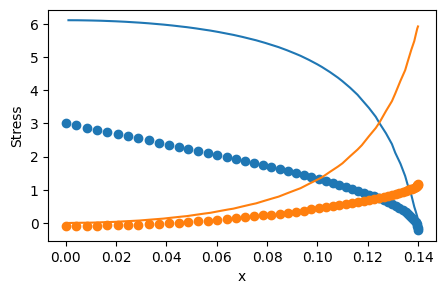

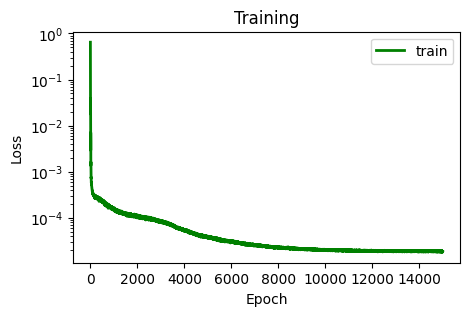

  0%|          | 1/15000 [00:00<3:37:30,  1.15it/s]

Stress Error: 21.16788529315289, after epoch: 0, grad von stress_y: 4.320890536884195


  3%|▎         | 501/15000 [07:07<3:24:33,  1.18it/s]

Stress Error: 21.084583909221628, after epoch: 500, grad von stress_y: 3.017031731684161


  7%|▋         | 1001/15000 [14:13<3:19:07,  1.17it/s]

Stress Error: 21.082944652528028, after epoch: 1000, grad von stress_y: 3.1101338570123103


 10%|█         | 1501/15000 [21:18<3:11:05,  1.18it/s]

Stress Error: 21.747684040619557, after epoch: 1500, grad von stress_y: 3.00534819244918


 13%|█▎        | 2001/15000 [28:23<3:03:31,  1.18it/s]

Stress Error: 21.823164588269545, after epoch: 2000, grad von stress_y: 2.829036868981402


 17%|█▋        | 2501/15000 [35:29<2:56:52,  1.18it/s]

Stress Error: 21.08620455130665, after epoch: 2500, grad von stress_y: 2.579307229966039


 20%|██        | 3001/15000 [42:34<2:50:39,  1.17it/s]

Stress Error: 20.537729574793964, after epoch: 3000, grad von stress_y: 2.295833499601592


 23%|██▎       | 3501/15000 [49:39<2:43:06,  1.17it/s]

Stress Error: 20.419485793437172, after epoch: 3500, grad von stress_y: 2.184481248044207


 27%|██▋       | 4001/15000 [56:45<2:36:28,  1.17it/s]

Stress Error: 20.156822527480767, after epoch: 4000, grad von stress_y: 2.082670248871803


 30%|███       | 4501/15000 [1:03:53<2:29:40,  1.17it/s]

Stress Error: 19.934127185058085, after epoch: 4500, grad von stress_y: 1.9718362635040412


 33%|███▎      | 5001/15000 [1:11:01<2:22:48,  1.17it/s]

Stress Error: 19.98332582026089, after epoch: 5000, grad von stress_y: 1.952234947213103


 37%|███▋      | 5501/15000 [1:18:09<2:14:50,  1.17it/s]

Stress Error: 19.445528899383994, after epoch: 5500, grad von stress_y: 2.00002069035


 40%|████      | 6001/15000 [1:25:17<2:07:53,  1.17it/s]

Stress Error: 18.89288938591514, after epoch: 6000, grad von stress_y: 2.0181718669981716


 43%|████▎     | 6501/15000 [1:32:23<2:00:08,  1.18it/s]

Stress Error: 18.473708396082923, after epoch: 6500, grad von stress_y: 2.0334489490997703


 47%|████▋     | 7001/15000 [1:39:28<1:53:15,  1.18it/s]

Stress Error: 18.224001344941737, after epoch: 7000, grad von stress_y: 2.0381009789518103


 50%|█████     | 7501/15000 [1:46:32<1:46:31,  1.17it/s]

Stress Error: 18.074890496785954, after epoch: 7500, grad von stress_y: 2.0397645318278204


 53%|█████▎    | 8001/15000 [1:53:38<1:38:50,  1.18it/s]

Stress Error: 17.95626710172772, after epoch: 8000, grad von stress_y: 2.0389402093748723


 57%|█████▋    | 8501/15000 [2:00:42<1:31:41,  1.18it/s]

Stress Error: 17.884367538018644, after epoch: 8500, grad von stress_y: 2.0377479459605263


 60%|██████    | 9001/15000 [2:07:47<1:24:32,  1.18it/s]

Stress Error: 17.807636386473632, after epoch: 9000, grad von stress_y: 2.034335990548934


 63%|██████▎   | 9501/15000 [2:14:52<1:17:45,  1.18it/s]

Stress Error: 17.77732976698235, after epoch: 9500, grad von stress_y: 2.0334128653124908


 67%|██████▋   | 10001/15000 [2:21:57<1:10:14,  1.19it/s]

Stress Error: 17.740718994717852, after epoch: 10000, grad von stress_y: 2.031310063237156


 70%|███████   | 10501/15000 [2:29:02<1:03:55,  1.17it/s]

Stress Error: 17.708768390868165, after epoch: 10500, grad von stress_y: 2.029611801666273


 73%|███████▎  | 11001/15000 [2:36:08<58:38,  1.14it/s]  

Stress Error: 17.691399757482483, after epoch: 11000, grad von stress_y: 2.028723258096238


 77%|███████▋  | 11501/15000 [2:43:13<49:22,  1.18it/s]

Stress Error: 17.673623769153313, after epoch: 11500, grad von stress_y: 2.0277370367532153


 80%|████████  | 12001/15000 [2:50:19<42:19,  1.18it/s]

Stress Error: 17.659053145482616, after epoch: 12000, grad von stress_y: 2.026800590247704


 83%|████████▎ | 12501/15000 [2:57:25<35:38,  1.17it/s]

Stress Error: 17.6492626004496, after epoch: 12500, grad von stress_y: 2.026211266460192


 87%|████████▋ | 13001/15000 [3:04:32<28:22,  1.17it/s]

Stress Error: 17.639668464245837, after epoch: 13000, grad von stress_y: 2.025574768341876


 90%|█████████ | 13501/15000 [3:11:39<21:11,  1.18it/s]

Stress Error: 17.633991884355922, after epoch: 13500, grad von stress_y: 2.025228936720296


 93%|█████████▎| 14001/15000 [3:18:46<14:08,  1.18it/s]

Stress Error: 17.62941968988654, after epoch: 14000, grad von stress_y: 2.0249608419755756


 97%|█████████▋| 14501/15000 [3:26:16<07:54,  1.05it/s]

Stress Error: 17.62454439034304, after epoch: 14500, grad von stress_y: 2.0246015510452686


100%|██████████| 15000/15000 [3:33:56<00:00,  1.17it/s]

iteration: 2, Weight_NEU: 0.00020934997883159667, Weight_PDE: 5.3551437304122373e-05, Stress Error: 17.620766891702857, lr_PDE: 3e-06
Weight_NEU gradient: 5069.2314453125,  Weight_PDE gradient: 22548.447265625


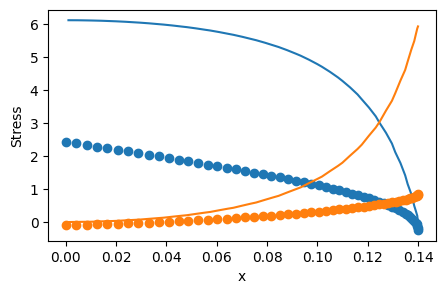

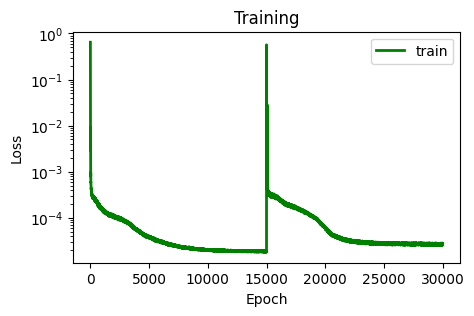

  0%|          | 1/15000 [00:00<4:08:37,  1.01it/s]

Stress Error: 115.28880285222942, after epoch: 0, grad von stress_y: 49.81335279338952


  0%|          | 49/15000 [00:45<3:52:02,  1.07it/s]


KeyboardInterrupt: 

In [286]:
# Epochs
epochs_adam = 15000 #2.5-3it/s -> 7min #previous value -> 5600
epochs_lbfgs = 0 
# Batch size
batch_size = 256 #previous value 64
# Learning rate
lr = 0.05 #previous value -> 0.005
weight_lr = 8.0e-07 #previous value -> 0.00001
lr_weights = 1.0e-05
# Scheduler step width
scheduler_step = 500
# Gamma factor of scheduler
scheduler_gamma = 0.84 # #previous value -> 0.6-0.8 or 0.55
exponential_gamma = 0.999 #previous value -> 0.9994162117



loss_history = []
weight_history = []
testruns = 16 #total amount of test runs
test = 1 #have to be 1
# Weight_PDE = 8.0e-06 #previous value -> 0.00005
# Weight_NEU = 7.999999999999999e-05 #previous value -> 0.0001
stressError = torch.tensor(24.0, requires_grad=True, device=device).retain_grad() #previous value 
#describes new weight = weight*factor for each step
#if(Error > previous Error ) -> factor = 1/factor
factor = 5
token = 0 #changes weight_case if token will be changed twice
weight_case = 1 #0->PDE; 1->NEU; 2->PDE and NEU; 3->no weight changes

data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]
data_stress_x = data_hole[:, 2]
data_stress_y = data_hole[:, 3]




#interpolate data_stress_x and data_stress_y
f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)


#previous Weight_NEU und Weight_PDE als PyTorch nn parameter 
# Weight_NEU = torch.nn.Parameter(torch.tensor(1.6e-05), requires_grad=True)
# Weight_PDE = torch.nn.Parameter(torch.tensor(8.0e-06), requires_grad=True)
#iteration: 26, Weight_NEU: 1.8841683879627231e-06, Weight_PDE: 3.1355081392423563e-06, Stress Error: 6.01981784519743, , lr: 7.700431458051553e-08

#Weight_NEU and Weight_PDE for hyperparameter optimization
Weight_NEU = torch.tensor(5.123499795445241e-05, requires_grad=True, device=device) #previous value -> 5.551547019422287e-06
Weight_PDE = torch.tensor(5.655143705647788e-06, requires_grad=True, device=device) #previous value -> 1.655143705647788e-06



def train_weights(W_neu, W_pde):

    # W_neu = W_neu.to(device)
    # W_pde = W_pde.to(device)
    
    #reset all network parameters    
    net.apply(weight_reset)
    
    #optimizer with parameter of nn and weights for optimization
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, differentiable= False)
    #scheduler = StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)
    #scheduler = ExponentialLR(optimizer, gamma=exponential_gamma)
    scheduler = MultiStepLR(optimizer, milestones=[100, 200, 400, 700, 1100, 1600, 2200, 2900, 3700, 4600, 5600,  9000], gamma=0.5)
    for epoch in tqdm(range(epochs_adam)):
        # Permutation to shuffle collocation points randomly in each epoch
        permutation = torch.randperm(collocation.size()[0])
        # if(epoch >= epochs_adam-1):
        #     print(f"ADAM Weight_NEU: {torch.abs(W_neu).item()}, ADAM Weight_PDE: {torch.abs(W_pde).item()}")

        for i in range(0, collocation.size()[0], batch_size):
            indices = permutation[i : i + batch_size]
            collo = collocation[indices]
            #collo = collo.to(device)
            #print(collo.device)
            #print("is cuda available: ",torch.cuda.is_available())
            hole_and_collo = torch.cat((collo, hole), 0)
            perm = torch.randperm(hole_and_collo.size(0))
            shuffled_hole_and_collo = hole_and_collo[perm]

            optimizer.zero_grad()

            # Compute physics losses
            left_l, right_l, bottom_l, top_l, hole_l, pde_l = compute_physics_losses(shuffled_hole_and_collo)

            # Aggregate losses
            dirichlet_losses = left_l + bottom_l 
            neumann_losses = right_l + top_l + hole_l

            loss = (
                dirichlet_losses
                + W_neu * neumann_losses #previous version: torch.abs(W_neu)
                + W_pde * pde_l #previous version: torch.abs(W_pde)
            )

            # compare computed stressError(PINN) with actual stressError
            stress_hole = torch.vmap(sigma)(hole)
            #stressError = mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x, device=device)) + mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y, device=device)).retain_grad
            stress_x = stress_hole[:, 0, 0].clone().detach().requires_grad_(True)
            stress_y = stress_hole[:, 1, 1].clone().detach().requires_grad_(True)
            mse_stress_hole_x = mse(stress_x, torch.tensor(y_stress_x, requires_grad=True, device=device))
            mse_stress_hole_y = mse(stress_y, torch.tensor(y_stress_y, requires_grad=True, device=device))
            stressError = mse_stress_hole_x + mse_stress_hole_y
            #compare just a single point of y_stress_y (stress value of 6.0)
            #stressError = mse(stress_hole[:, 1, 1][0], torch.tensor(y_stress_y[0], device=device))

            # Make optimization step after batch
            loss.backward(retain_graph=True)
            stressError.backward(retain_graph=True)

            optimizer.step()

        # Make scheduler step after full epoch
        scheduler.step()
        if(epoch % 500 == 0):
            print(f"Stress Error: {stressError}, after epoch: {epoch}, grad von stress_y: {mse_stress_hole_y}")

        # append loss to history (important for plotting)
        with torch.autograd.no_grad():
            loss_history.append(float(loss.data))
    

    
    return stressError



optimizer_weights = torch.optim.Adam([Weight_NEU, Weight_PDE], lr=lr_weights)
scheduler_weights = StepLR(optimizer_weights, step_size=10, gamma=0.9)
for i in range(testruns):
    optimizer_weights.zero_grad()
    mse_error = train_weights(Weight_NEU, Weight_PDE)

    # print weights and stress error 
    print(f"iteration: {i+1}, Weight_NEU: {Weight_NEU.item()}, Weight_PDE: {Weight_PDE.item()}, Stress Error: {mse_error.item()}, lr_PDE: {optimizer_weights.param_groups[0]['lr']}")#, lr_PDE: {optimizer_PDE.param_groups[0]['lr']}")
    mse_error.backward()
    optimizer_weights.step()

    # Weight_NEU = torch.clamp(Weight_NEU, min= torch.tensor(0.0, requires_grad=True, device=device))
    # Weight_PDE = torch.clamp(Weight_PDE, min= torch.tensor(0.0, requires_grad=True, device=device))
    print(f"Weight_NEU gradient: {Weight_NEU.grad},  Weight_PDE gradient: {Weight_PDE.grad}")
    

    with torch.autograd.no_grad():
        weight_history.append(float(mse_error.data))
        stress_hole = torch.vmap(sigma)(hole)
        plt.figure(figsize=(5, 3))
        plt.plot(hole[:, 0].cpu(), stress_hole[:, 0, 0].cpu(), "o", color="tab:blue", label="σ_xx (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
        plt.plot(hole[:, 0].cpu(), stress_hole[:, 1, 1].cpu(), "o", color="tab:orange", label="σ_yy (PINN)")
        plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
        plt.xlabel("x")
        plt.ylabel("Stress")
        #plt.legend()

        plt.figure(figsize=(5, 3))
        plt.plot(loss_history, c='g', label='train', linewidth=2.0)
        plt.yscale("log")
        plt.title("Training")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend()
        plt.show()
        




## Visualization of results

the final x_stress Error is 24.0


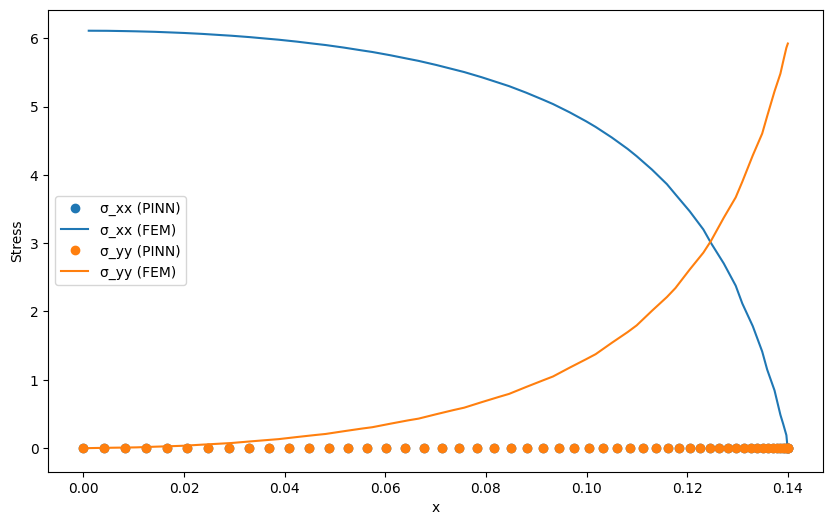

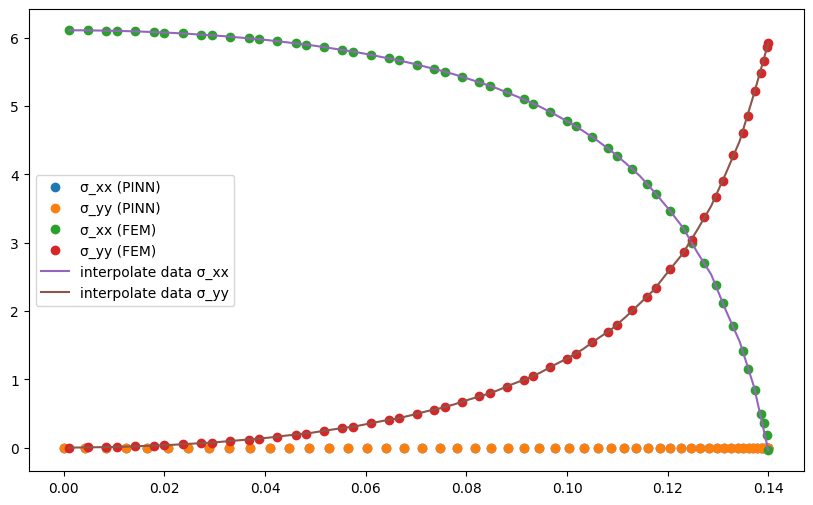

In [ ]:
from scipy.interpolate import interp1d


stress_hole = torch.vmap(sigma)(hole)
data_hole = np.loadtxt(f"data/hole_Rx={Rx}.csv", delimiter=",")
data_hole = data_hole[data_hole[:, 0].argsort()]

#stressError = mse(stress_hole[:, 1, 1], torch.tensor(y_stress_y)) + mse(stress_hole[:, 0, 0], torch.tensor(y_stress_x)) 
print("the final x_stress Error is", stressError.item())

with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(hole[:, 0].cpu(), stress_hole[:, 0, 0].cpu(), "o", color="tab:blue", label="σ_xx (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 2], "-", color="tab:blue", label="σ_xx (FEM)")
    plt.plot(hole[:, 0].cpu(), stress_hole[:, 1, 1].cpu(), "o", color="tab:orange", label="σ_yy (PINN)")
    plt.plot(data_hole[:, 0], data_hole[:, 3], "-", color="tab:orange", label="σ_yy (FEM)")
    plt.xlabel("x")
    plt.ylabel("Stress")
    plt.legend()
    plt.show()

f_stress_x = interp1d(data_hole[:, 0], data_hole[:, 2], kind='cubic')
f_stress_y = interp1d(data_hole[:, 0], data_hole[:, 3], kind='cubic')
x_new = np.linspace(data_hole[:, 0][0], data_hole[:, 0][-1], 50)
#x_new = np.linspace(data_hole[:, 0][-1], data_hole[:, 0][0], hole[:, 0].size(dim=0))
y_stress_x = f_stress_x(x_new)
y_stress_y = f_stress_y(x_new)



# plt.plot(data_hole[:, 0], data_hole[:, 2],'o', x_new, y_stress_x)
# plt.plot(data_hole[:, 0], data_hole[:, 3],'o', x_new, y_stress_y)
# plt.xlim([data_hole[:, 0][0]-1, data_hole[:, 0][-1] + 1 ])
# plt.show()

# Erstellen Sie das Plot
with torch.no_grad():
    plt.figure(figsize=(10, 6))
    plt.plot(hole[:, 0].cpu(), stress_hole[:, 0, 0].cpu(), 'o', label='σ_xx (PINN)')
    plt.plot(hole[:, 0].cpu(), stress_hole[:, 1, 1].cpu(), 'o', label='σ_yy (PINN)')
    plt.plot(data_hole[:, 0], data_hole[:, 2], 'o', label='σ_xx (FEM)')
    plt.plot(data_hole[:, 0], data_hole[:, 3], 'o', label='σ_yy (FEM)')
    plt.plot(x_new, y_stress_x, '-', label='interpolate data σ_xx')
    plt.plot(x_new, y_stress_y, '-', label='interpolate data σ_yy')
    plt.legend()
    plt.show()


In [ ]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_domain = np.vstack([val_x.ravel(), val_y.ravel()]).T
mask = (
    ((val_domain[:, 0] ** 2) / (Rx**2)) + ((val_domain[:, 1] ** 2) / (Ry**2))
) > 1
val = torch.tensor(val_domain[mask], requires_grad=True, device= device)
val = val.float()

# Compute model predictions on the validation domain
disp = net(val)
def_val = val + disp
stress = torch.vmap(sigma)(val)
mises = torch.sqrt(
    stress[:, 0, 0] ** 2
    + stress[:, 1, 1] ** 2
    - stress[:, 0, 0] * stress[:, 1, 1]
    + 3 * stress[:, 0, 1] ** 2
)
# print([loss.item() for loss in compute_les(val)])


@torch.no_grad()
def make_plot(x, y, variable, title, cmap=sequential.Viridis, size=8.0):
    fig = go.Figure()

    # Plot boundaries
    m = dict(color="black")
    fig.add_trace(go.Scatter(x=top[:, 0].cpu(), y=top[:, 1].cpu(), mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=bottom[:, 0].cpu(), y=bottom[:, 1].cpu(), mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=left[:, 0].cpu(), y=left[:, 1].cpu(), mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=right[:, 0].cpu(), y=right[:, 1].cpu(), mode="lines", marker=m))
    fig.add_trace(go.Scatter(x=hole[:, 0].cpu(), y=hole[:, 1].cpu(), mode="lines", marker=m))

    # Plot variable values
    m = dict(color=variable, colorscale=cmap, size=size, colorbar=dict(thickness=10))
    fig.add_trace(go.Scatter(x=x, y=y, marker=m, mode="markers"))

    # plot settings
    fig.layout.yaxis.scaleanchor = "x"
    fig.update_layout(
        template="none", width=400, height=400, title=title, showlegend=False
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()


# Compute data error
s_data = data_output[:, 0:3]
s_pred = torch.vmap(sigma)(data_input[:, 0:2])
ds_xx = s_data[:, 0] - s_pred[:, 0, 0]
ds_yy = s_data[:, 1] - s_pred[:, 1, 1]
ds_xy = s_data[:, 2] - s_pred[:, 0, 1]


# Plot stress errors
cmap = sequential.RdBu_r
make_plot(*data_input[:, 0:2].T.cpu(), ds_xx.cpu(), "Stress error xx", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T.cpu(), ds_yy.cpu(), "Stress error yy", size=2.0, cmap=cmap)
make_plot(*data_input[:, 0:2].T.cpu(), ds_xy.cpu(), "Stress error xy", size=2.0, cmap=cmap)

# Plot stresses
make_plot(*def_val.T.cpu(), stress[:, 0, 0].cpu(), "Stress xx")
make_plot(*def_val.T.cpu(), stress[:, 0, 1].cpu(), "Stress xy")
make_plot(*def_val.T.cpu(), stress[:, 1, 1].cpu(), "Stress yy")
make_plot(*def_val.T.cpu(), mises.cpu(), "Mises stress")

# Plot displacements
make_plot(*def_val.T.cpu(), disp[:, 0].cpu(), "Displacement in x", cmap=sequential.Inferno)
make_plot(*def_val.T.cpu(), disp[:, 1].cpu(), "Displacement in y", cmap=sequential.Inferno)


In [ ]:
#zwischenablage

            # if W_DISP < 1E-10 and W_STRESS < 1E-10:
            #     # No data losses needed (we can accelerate training by skipping this part)
            #     stress_l = 0.0
            #     disp_l = 0.0
            # else:
            #     # Get samples from reference solution
            #     samples = torch.randperm(data_output.size()[0])[::100]
            #     # Reference solutions
            #     s_data = data_output[samples, 0:3]
            #     e_data = data_output[samples, 4:7]
            #     u_data = data_output[samples, 7:10]
            #     # Predictions
            #     s_pred = torch.vmap(sigma)(data_input[samples, 0:2])
            #     e_pred = torch.vmap(epsilon)(data_input[samples, 0:2])
            #     u_pred = net(data_input[samples, 0:2])
            #     # Compute data losses
            #     ds_xx = mse(s_data[:, 0], s_pred[:, 0, 0])
            #     ds_yy = mse(s_data[:, 1], s_pred[:, 1, 1])
            #     ds_xy = mse(s_data[:, 2], s_pred[:, 0, 1])
            #     stress_l = ds_xx + ds_yy + ds_xy
            #     du_x = mse(u_data[:, 0], u_pred[:, 0])
            #     du_y = mse(u_data[:, 1], u_pred[:, 1])
            #     disp_l = du_x + du_y